
## In this exercise, we will use the HR dataset and understand the following:

> 1. Building the logistic regression model
2. Writing the model equation and interpreting the model summary
3. Finding the variable which is leading to quasi complete seperation
4. Creating the Confusion Matrix and ROC plot on train data (This is self work/assignment)
5. Using mis-classification cost as a criteria to select the best cut-off
6. Using Younden Index as the criteria to select the best cut-off
7. Creating the Confusion Matrix and ROC plot on test data
8. Changing the base or reference category and evaluate the impact on the model

There are bugs/missing code in the entire exercise. The participants are expected to work upon them.
***
***

## Here are some useful links:

> 1. **[Read](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/dummy.htm)** about interaction variable coding
2. Refer **[link](http://www.statmethods.net/input/valuelabels.html)** to know about adding lables to factors
3. Refer **[link](http://stackoverflow.com/questions/2342472/recode-relevel-data-frame-factors-with-different-levels)** to relvel factor variables
4. **[Read](http://stats.stackexchange.com/questions/88485/variable-is-significant-through-stepwise-regression-but-not-in-final-models-sum)** about the issues in stepwise regression
5. **[Read](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/complete_separation_logit_models.htm)** about the issue of Quasi seperation

***

# Code starts here

We are going to use below mentioned libraries for demonstrating logistic regression:



In [1]:
library(stats)    #for binary logistic without wald statistics
#library(Deducer)  #for ROC plot
library(ROCR)     #for ROC plot (other way)
library(caret)    #for data partition. Model building
#library(ResourceSelection) #Hosmer lemeshow GoF test

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: lattice
Loading required package: ggplot2



## Data Import and Manipulation

### 1. Importing a data set

_Give the correct path to the data_


In [2]:
raw_df <- read.csv("/Users/Rahul/Documents/Datasets/IMB533_HR_Data_No_Missing_Value.csv", header = TRUE,sep = ",",na.strings = c(""," ", "NA"))


Note that `echo = FALSE` parameter prevents printing the R code that generated the
plot.

### 2. Structure and Summary of the dataset



In [3]:
str(raw_df)
summary(raw_df)

'data.frame':	8995 obs. of  18 variables:
 $ SLNO                       : int  1 2 3 4 5 6 7 9 11 12 ...
 $ Candidate.Ref              : int  2110407 2112635 2112838 2115021 2115125 2117167 2119124 2127572 2138169 2143362 ...
 $ DOJ.Extended               : Factor w/ 2 levels "No","Yes": 2 1 1 1 2 2 2 2 1 1 ...
 $ Duration.to.accept.offer   : int  14 18 3 26 1 17 37 16 1 6 ...
 $ Notice.period              : int  30 30 45 30 120 30 30 0 30 30 ...
 $ Offered.band               : Factor w/ 4 levels "E0","E1","E2",..: 3 3 3 3 3 2 3 2 2 2 ...
 $ Pecent.hike.expected.in.CTC: num  -20.8 50 42.8 42.8 42.6 ...
 $ Percent.hike.offered.in.CTC: num  13.2 320 42.8 42.8 42.6 ...
 $ Percent.difference.CTC     : num  42.9 180 0 0 0 ...
 $ Joining.Bonus              : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ Candidate.relocate.actual  : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 1 1 1 1 1 ...
 $ Gender                     : Factor w/ 2 levels "Female","Male": 1 2 2 2 2 2 2 1 1 2 ...
 $ 

      SLNO       Candidate.Ref     DOJ.Extended Duration.to.accept.offer
 Min.   :    1   Min.   :2109586   No :4788     Min.   :  0.00          
 1st Qu.: 3208   1st Qu.:2386476   Yes:4207     1st Qu.:  3.00          
 Median : 5976   Median :2807482                Median : 10.00          
 Mean   : 5971   Mean   :2843647                Mean   : 21.43          
 3rd Qu.: 8739   3rd Qu.:3300060                3rd Qu.: 33.00          
 Max.   :12333   Max.   :3836076                Max.   :224.00          
                                                                        
 Notice.period    Offered.band Pecent.hike.expected.in.CTC
 Min.   :  0.00   E0: 211      Min.   :-68.83             
 1st Qu.: 30.00   E1:5568      1st Qu.: 27.27             
 Median : 30.00   E2:2711      Median : 40.00             
 Mean   : 39.29   E3: 505      Mean   : 43.86             
 3rd Qu.: 60.00                3rd Qu.: 53.85             
 Max.   :120.00                Max.   :359.77             
   



Create a new data frame and store the raw data copy. This is being done to have a copy of the raw data intact for further manipulation if needed.



In [4]:
filter_df <- na.omit(raw_df) # listwise deletion of missing


### 3. Relevel

By default, the base category/reference category selected is ordered alphabetically. In this data set, Status has two classes (Joined/Not Joined). Since 'J' appears first compared to 'N' in alphabet sequence, So Joined will be marked as the base category.

The base category can be releveled using the function **relevel()**.



In [5]:
#filter_df$Status <- relevel(filter_df$Status, ref = "Not Joined")



### 4. Create train and test dataset

#### Reserve 80% for **_training_** and 20% of **_test_**

_Correct the error in the below code chunk_


In [6]:
#set.seed(2341)
trainIndex <- createDataPartition(filter_df$Status, p = 0.80, list = FALSE)
train_df <- filter_df[trainIndex,]
test_df <- filter_df[-trainIndex,]


We can pull the specific attribute needed to build the model is another data frame. This agian is more of a hygine practice to not touch the **train** and **test** data set directly.

_Correct the error in the below code chunk_


In [7]:
lg_train_df <- as.data.frame(train_df[,c("DOJ.Extended",
                                             "Duration.to.accept.offer",
                                             "Notice.period",
                                             "Offered.band",
                                             "Percent.difference.CTC",
                                             "Joining.Bonus",
                                             #"Candidate.relocate.actual",
                                             "Gender",
                                             "Candidate.Source",
                                             "Rex.in.Yrs",
                                             "LOB",
                                             "Location",
                                             "Age",
                                             "Status"
)])


_Correct the error in the below code chunk_


In [8]:
lg_test_df <- as.data.frame(test_df[,c("DOJ.Extended",
                                           "Duration.to.accept.offer",
                                           "Notice.period",
                                           "Offered.band",
                                           "Percent.difference.CTC",
                                           "Joining.Bonus",
                                           #"Candidate.relocate.actual",
                                           "Gender",
                                           "Candidate.Source",
                                           "Rex.in.Yrs",
                                           "LOB",
                                           "Location",
                                           "Age",
                                           "Status"
)])


***

## Model building: Using the **glm()** function

The actual model building starts now. Note that we are demonstrating the strategy of building a step wise model (forward selection and backward elimination)  using the glm function



In [9]:
#Null Model
no_model <- glm(Status ~ 1,data = lg_train_df, family = binomial)

#Full Model
lg_full_model = glm(Status ~ .
                     , data = lg_train_df, family = binomial)

#Stepwise - Forward selection backward elimination
lg_stepwise_model <- step(no_model, list(lower = formula(no_model),
                                         upper = formula(lg_full_model)),
                           direction = "both",trace = 0)



***

## Model Evaluation

### 1. ROC plot and Model summary of Train Data

Checking the hosmer lemeshow value and the ROC plot using the deducer package. Note that this evaluation is on training data.



In [10]:
#hoslem.test(lg_stepwise_model$y, fitted(lg_stepwise_model)) #Hosmer lemeshow test
#rocplot(lg_stepwise_model)
summary(lg_stepwise_model)


Call:
glm(formula = Status ~ Notice.period + Candidate.Source + LOB + 
    Offered.band + Age + DOJ.Extended + Location + Rex.in.Yrs, 
    family = binomial, data = lg_train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3858  -0.6805  -0.5411  -0.3650   2.6317  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         1.502206   1.190984   1.261  0.20720    
Notice.period                       0.019438   0.001412  13.763  < 2e-16 ***
Candidate.SourceDirect             -0.363852   0.072513  -5.018 5.23e-07 ***
Candidate.SourceEmployee Referral  -0.727345   0.106219  -6.848 7.51e-12 ***
LOBBFSI                            -0.236436   0.147849  -1.599  0.10978    
LOBCSMP                            -0.169185   0.171772  -0.985  0.32465    
LOBEAS                              0.258771   0.191118   1.354  0.17574    
LOBERS                             -0.222430   0.140140  -1.587  0.11247    



### 2. The optimal cut-off



In [11]:
#creating empty vectors to store the results.
msclaf_cost <- c()
youden_index <- c()
cutoff <- c()
P11 <- c() #correct classification of positive as positive
P00 <- c() #correct classification of negative as negative
P10 <- c() #misclassification of positive class to negative class
P01 <- c() #misclassification of negative class to positive class


#### Select the optimal cut-off value, if:
> 1. cost of misclassifying Not Joined as Joined is twice as costly as cost of
micalssifying Joined as Not Joined
2. both sensitivity and specificity are equally important

The best cut-off is the one which minimizes the misclassification cost (in case of **_option 1_**) or which maximizes the Youden's Index (in case of **_Option 2_**). The misclassification cost table is

_fix the bug here_: clue is in the above **two options**


In [12]:
train_predicted_prob = predict.glm(lg_stepwise_model, lg_train_df, type = "response")
#variable with all the values as joined
n <- length(lg_train_df$Status)

costs = matrix(c(0,2,1, 0), ncol = 2)
colnames(costs) = rownames(costs) = c("Joined", "Non Joined")
as.table(costs)

           Joined Non Joined
Joined          0          1
Non Joined      2          0


The misclassification cost table is:


In [13]:
# defining log odds in favor of Non Default
for (i in seq(0.05, 1, .05)) {
  predicted_y = rep("Joined", n)
  predicted_y[train_predicted_prob > i] = "Not Joined"
  tbl <- table(lg_train_df$Status, predicted_y)
  if ( i <= 1) {
    #Classifying Not Joined as Joined
    P10[20*i] <- tbl[2]/(tbl[2] + tbl[4])

    P11[20*i] <- tbl[4]/(tbl[2] + tbl[4])

    #Classifying Joined as Not Joined
    P01[20*i] <- tbl[3]/(tbl[1] + tbl[3])

    P00[20*i] <- tbl[1]/(tbl[1] + tbl[3])

    cutoff[20*i] <- i
    msclaf_cost[20*i] <- P10[20*i]*costs[2] + P01[20*i]*costs[3]
    youden_index[20*i] <- P11[20*i] + P00[20*i] - 1
  }
}
df_cost_table <- cbind(cutoff,P10,P01,msclaf_cost, P11, P00, youden_index)


The table summarizing the optimal cut-off value:

_write the cost.table into a csv file_


In [14]:
df_cost_table
#write.csv(df_cost_table, "Optimal_Cutoff_stats.csv")

cutoff,P10,P01,msclaf_cost,P11,P00,youden_index
0.05,0.008172363,0.9659887199,0.9823334,0.991827637,0.03401128,0.0258389176
0.10,0.074294205,0.7814048881,0.9299933,0.925705795,0.21859511,0.1443009069
0.15,0.217682021,0.5510169202,0.9863810,0.782317979,0.44898308,0.2313010590
0.20,0.416047548,0.3310545206,1.1631496,0.583952452,0.66894548,0.2528979311
0.25,0.598811293,0.1762091950,1.3738318,0.401188707,0.82379080,0.2249795123
0.30,0.751114413,0.0924628269,1.5946917,0.248885587,0.90753717,0.1564227601
0.35,0.852897474,0.0493932661,1.7551882,0.147102526,0.95060673,0.0977092599
0.40,0.901931649,0.0249529995,1.8288163,0.098068351,0.97504700,0.0731153512
0.45,0.937592868,0.0145274312,1.8897132,0.062407132,0.98547257,0.0478797010
0.50,0.970282318,0.0059818834,1.9465465,0.029717682,0.99401812,0.0237357986




### 3. Confusion Matrix on the test data

The **predict** function is used to get the predicted probability on the new dataset. The probability value along with the optimal cut-off can be used to build confusion matrix



In [15]:
test_predicted_prob = predict(lg_stepwise_model, lg_test_df, type = "response")

#variable with all the values as joined
n <- length(lg_test_df$Status)
predicted_y = rep("Joined", n)

# defining log odds in favor of not joining
predicted_y[test_predicted_prob > 0.10] = "Not Joined"

#add the model_precition in the data
lg_test_df$predicted_y <- predicted_y

###Create the confusionmatrix###
addmargins(table(lg_test_df$Status, lg_test_df$predicted_y))
mean(lg_test_df$predicted_y == lg_test_df$Status)

,Joined,Not Joined,Sum
Joined,359,1103,1462
Not Joined,28,308,336
Sum,387,1411,1798


[1] 0.3709677



### 4. ROC Plot on the test data

ROCR package can be used to evaluate the model performace on the test data. The same package can also be used to get the model performace on the test data.



An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.7136119


Slot "alpha.values":
list()


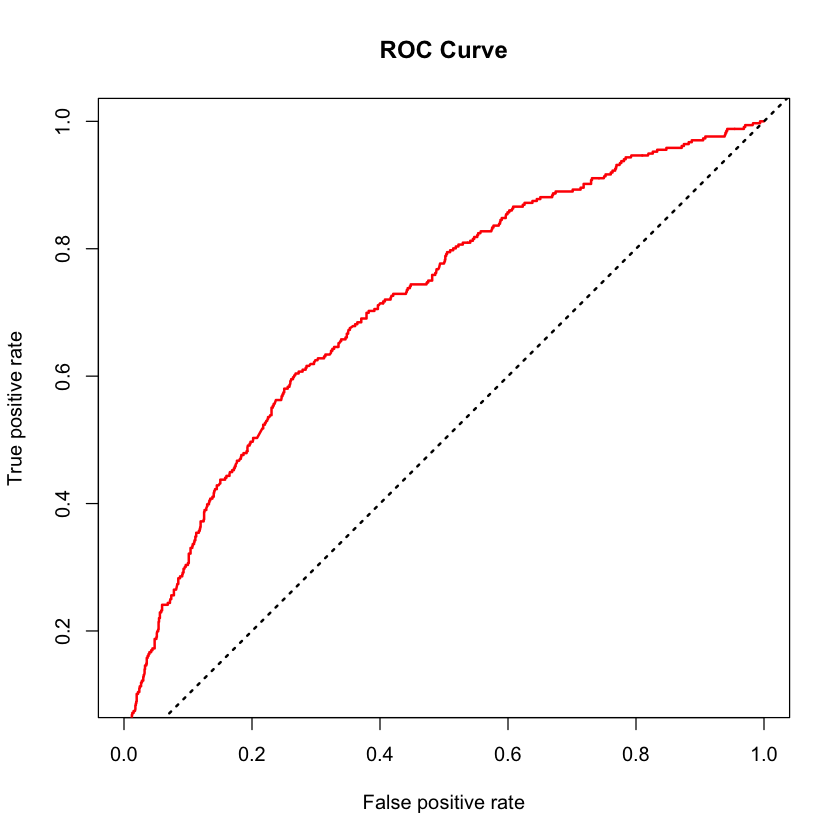

In [16]:
lgPredObj <- prediction(test_predicted_prob,lg_test_df$Status)
lgPerfObj <- performance(lgPredObj, "tpr","fpr")
plot(lgPerfObj,ylim=c(0.1, 1), main = "ROC Curve",col = 2,lwd = 2)
abline(a = 0,b = 1,lwd = 2,lty = 3,col = "black")
performance(lgPredObj, "auc")



#### End of Document

***
***
